In [2]:
import abjad
string = "c'16 f' g' a' d' g' a' b' e' a' b' c'' f' b' c'' d''16"
voice_1 = abjad.Voice(string, name="Voice_1")
staff_1 = abjad.Staff([voice_1], name="Staff_1")
abjad.show(staff_1)

In [7]:
from pytube import YouTube
yt = YouTube('https://www.youtube.com/watch?v=UtGNBYegDBc')

print(yt.streams.filter(type='video'))
yt.streams.get_by_itag(137).download()

[<Stream: itag="17" mime_type="video/3gpp" res="144p" fps="7fps" vcodec="mp4v.20.3" acodec="mp4a.40.2" progressive="True" type="video">, <Stream: itag="18" mime_type="video/mp4" res="360p" fps="30fps" vcodec="avc1.42001E" acodec="mp4a.40.2" progressive="True" type="video">, <Stream: itag="22" mime_type="video/mp4" res="720p" fps="30fps" vcodec="avc1.64001F" acodec="mp4a.40.2" progressive="True" type="video">, <Stream: itag="137" mime_type="video/mp4" res="1080p" fps="30fps" vcodec="avc1.640028" progressive="False" type="video">, <Stream: itag="134" mime_type="video/mp4" res="360p" fps="30fps" vcodec="avc1.4d401e" progressive="False" type="video">]


'/Users/paolomuratore/Documents/Code/Music Sheet/exile - Taylor Swift & Bon Iver  Piano Tutorial.mp4'

In [177]:
import cv2
import numpy as np
from PIL import Image

from typing import Tuple, List

def mse(a : np.ndarray, b : np.ndarray, axis : int | None = None) -> float | np.ndarray:
    return np.square(a - b).mean(axis = axis)

def frame_to_float(frame : np.ndarray) -> np.ndarray:
    return frame.astype(float) / 255.

def frame_to_int(frame : np.ndarray) -> np.ndarray:
    frame = frame.clip(min=0, max=1)

    return (frame * 255).astype(np.uint8)

def trim_frame(frame : np.ndarray, trim : int = 250) -> np.ndarray:
    return frame[-trim:, :].mean(axis=-1) / 255.

def is_keyboard(frame : np.ndarray) -> bool:
    return frame.mean() < .62 and frame.mean() > .61

def frame_threshold(frame : np.ndarray, cutoff : Tuple[float, float] = (0, 1)) -> np.ndarray:
    cmin, cmax = cutoff
    frame[frame < cmin] = 0
    frame[frame > cmax] = 1

    return frame

def frame_to_pil(frame : np.ndarray) -> Image.Image:    
    if frame.dtype == float: frame = frame_to_int(frame)
    
    return Image.fromarray(frame)

def skip_intro(
    capture : cv2.VideoCapture
) -> Tuple[np.ndarray, int]:
    # Skip the video introduction
    skipped = 0
    ret, frame = capture.read()
    frame = trim_frame(frame)

    while not is_keyboard(frame):
        ret, frame = capture.read()
        frame = trim_frame(frame)

        skipped += 1

    return frame, skipped

def go_to_next(
    capture : cv2.VideoCapture,
    old_frame : np.ndarray,
    thr : float = 1e-3
) -> Tuple[np.ndarray, int]:
    new_frame = old_frame.copy()
    skipped = 0
    while mse(new_frame, old_frame) < thr:
        ret, new_frame = capture.read()  
        new_frame = trim_frame(new_frame)

        skipped += 1

    return new_frame, skipped

video_path = 'video/exile - Taylor Swift & Bon Iver  Piano Tutorial.mp4'

capture = cv2.VideoCapture(video_path)

clean_keyboard, skipped = skip_intro(capture)
data = (clean_keyboard, skipped)

music = [data := go_to_next(capture, data[0], thr=5e-4) for i in range(10)]
frames = [clean_keyboard] + [frame for frame, _ in music]
times  = [skipped] + [time  for _, time  in music]

In [341]:
from itertools import cycle

def bbox_notes(
    frame : np.ndarray,
    noise_cutoff : float = (2e-1, 1),
    min_box_area : int = 100,
    relative_coord : float = True,
) -> List[Tuple[int, int, int, int]]:
    '''
        This function identifies the bounding boxes around
        each note in the image.

        Returns:
        - bboxes: List of 4-tuples where each tuple is the bounding
            box around each detected note. The bbox format is (x, y, w, h)
    '''
    # Use thresholding to reduce frame noise and void false detection
    frame = frame_threshold(frame, cutoff=noise_cutoff)

    frame = frame_to_int(frame)

    # Use OpenCV to find object contours
    contours, _ = cv2.findContours(frame, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Filter contours by minimum spanning area
    filtered_contours = [contour for contour in contours if cv2.contourArea(contour) > min_box_area]

    # Find the bounding boxes for the notes
    bboxes = [cv2.boundingRect(contour) for contour in filtered_contours]

    # If relative coordinates are requested, we rescale them based on the
    # input dimension of the original frame
    if relative_coord:
        H, W = frame.shape
        bboxes = [(x / W, y / H, w / W, h / H) for x, y, w, h in bboxes]
        
    return bboxes

def get_keyboard_layout(
    start_note : str = 'C',
    end_note : str = 'B',
    num_octaves : int = 7,
    start_octave : int = 1,
    separate_bw : bool = False,
    black_key_notation : str = 'sharp',
    trim_black_borders : bool = False,
) -> List[str] | Tuple[List[str], List[str]]:
    '''
        Generate the keyboard layout based on the start and end note.
    '''

    white_notes = ['C', 'D', 'E', 'F', 'G', 'A', 'B']
    black_sharp = ['C#', 'D#', None, 'F#', 'G#', 'A#', None]
    black_bemol = [None, 'Db', 'Eb', None, 'Gb', 'Ab', 'Bb']

    match black_key_notation:
        case 'sharp':   black_notes = black_sharp
        case 'bemolle': black_notes = black_bemol
        case _: raise ValueError(f'Unknown black key notation: {black_key_notation}')

    octaves = list(map(str, np.repeat(range(num_octaves), len(white_notes)) + start_octave)) + [str(num_octaves + start_octave)]
    white_kb = ['-'.join((str(note), octave)) for note, octave in zip(cycle(white_notes), octaves)]
    black_kb = ['-'.join((str(note), octave)) for note, octave in zip(cycle(black_notes), octaves)]
    white_kb = white_kb[white_notes.index(start_note):-(len(white_notes) - white_notes.index(end_note))]
    black_kb = black_kb[white_notes.index(start_note):-(len(black_notes) - white_notes.index(end_note))]

    if separate_bw:
        if trim_black_borders:
            black_kb = black_kb[:-1] if black_key_notation == 'sharp' else black_kb[1:]
            
        black_kb = [note for note in black_kb if 'None' not in note]

        keyboard = (white_kb, black_kb)

    else:
        keyboard = [(w, b) if black_key_notation == 'sharp' else (b, w) for w, b in zip(white_kb, black_kb)]
        keyboard = [note for pair in keyboard for note in pair]

        if trim_black_borders:
            keyboard = keyboard[:-1] if black_key_notation == 'sharp' else keyboard[1:]
        keyboard = [note for note in keyboard if 'None' not in note]

    return keyboard

In [348]:
w, b = get_keyboard_layout(
    separate_bw=True,
    num_octaves=3,
    start_octave=2,
    start_note='D',
    end_note='B',
    black_key_notation='sharp',
    trim_black_borders=True
)

In [351]:
import numpy as np

def get_keyboard_spacings(
    keyboard_layout : Tuple[List[str], List[str]],
):
    # White spacings are easy as they are all equidistance
    white_kb, black_kb = keyboard_layout

    white_sp = np.linspace(0., 1. - 1 / len(white_kb), num = len(white_kb)) + .5 / len(white_kb)

    # Special care is needed for black spacings

    return white_sp

In [352]:
get_keyboard_spacings((w, b))

array([0.025, 0.075, 0.125, 0.175, 0.225, 0.275, 0.325, 0.375, 0.425,
       0.475, 0.525, 0.575, 0.625, 0.675, 0.725, 0.775, 0.825, 0.875,
       0.925, 0.975])

In [289]:
bbox_notes(frames[1] - frames[0])

[(0.296875, 0.0, 0.011458333333333333, 0.6),
 (0.20833333333333334, 0.0, 0.011458333333333333, 0.6)]

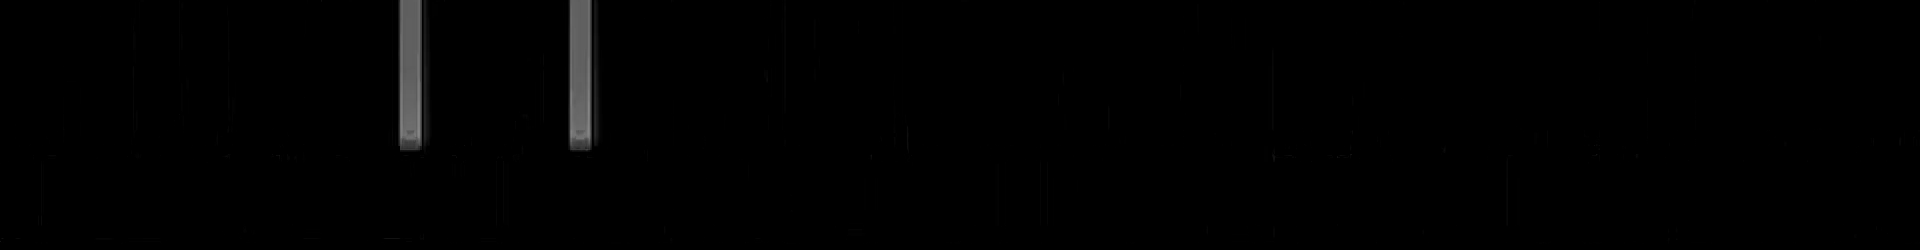

In [182]:
img = frame_to_pil((frames[1] - frames[0]))
img

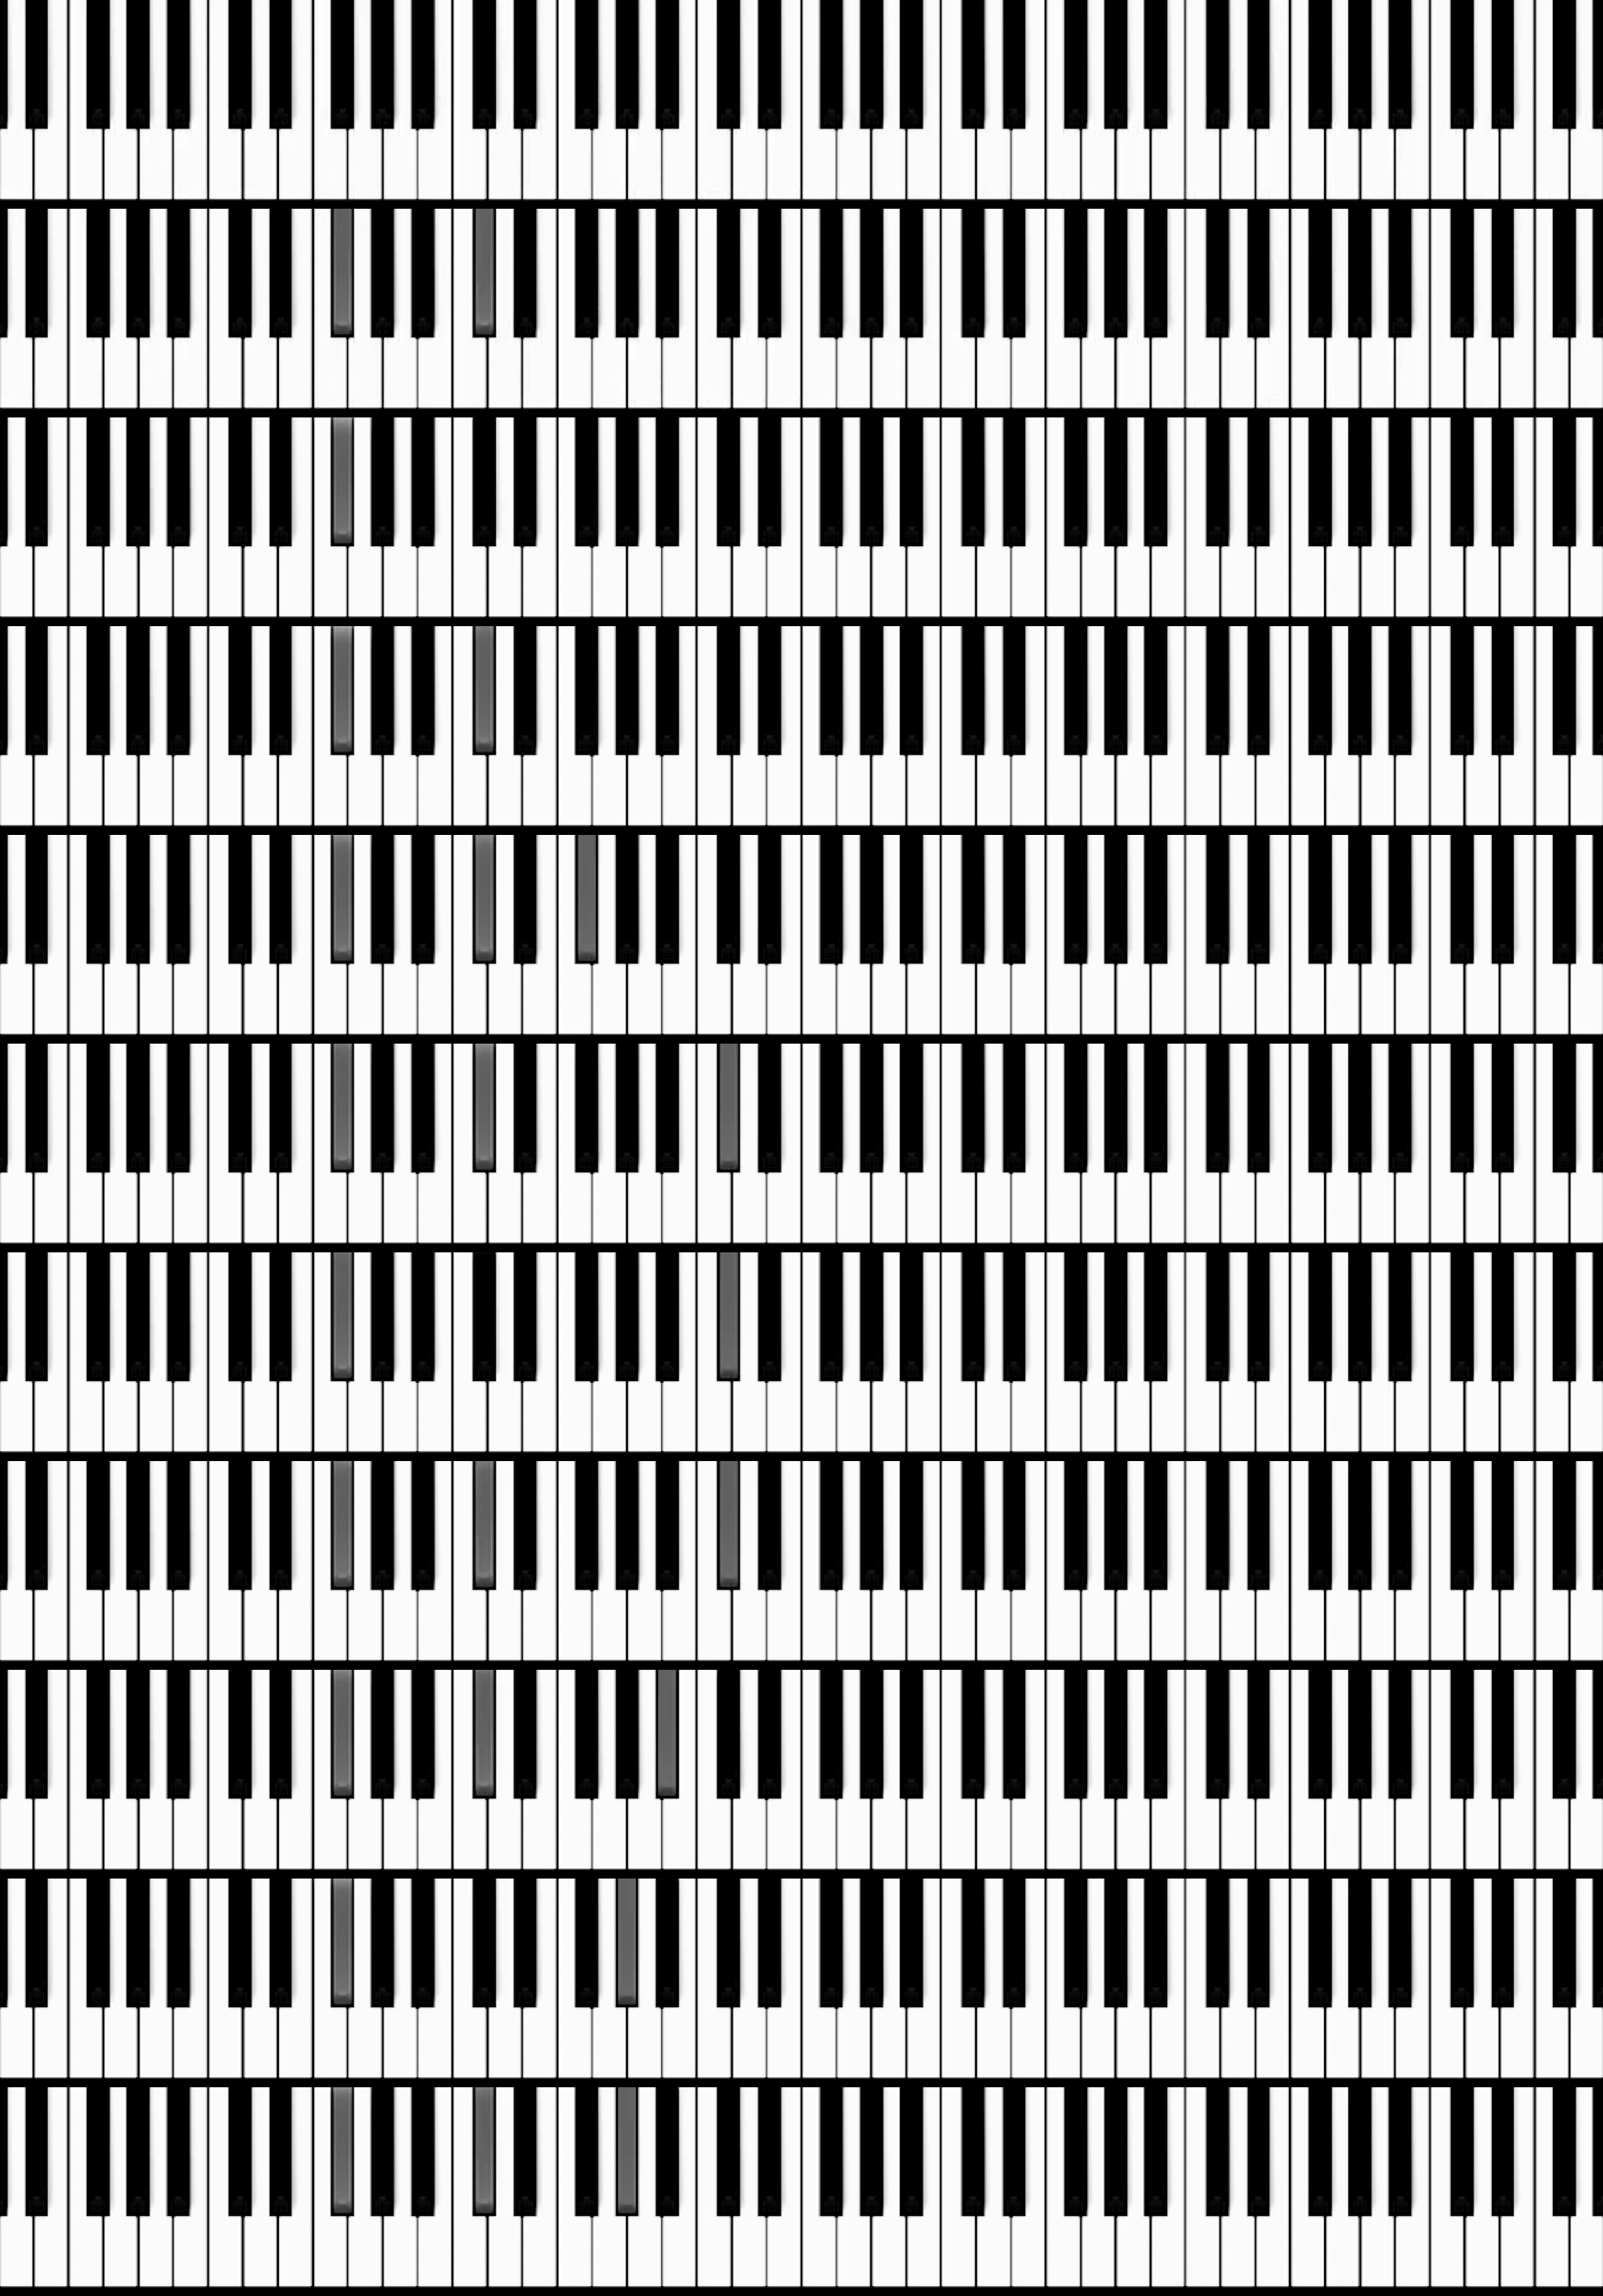

In [149]:
seq = np.vstack(frames)

frame_to_pil(seq)

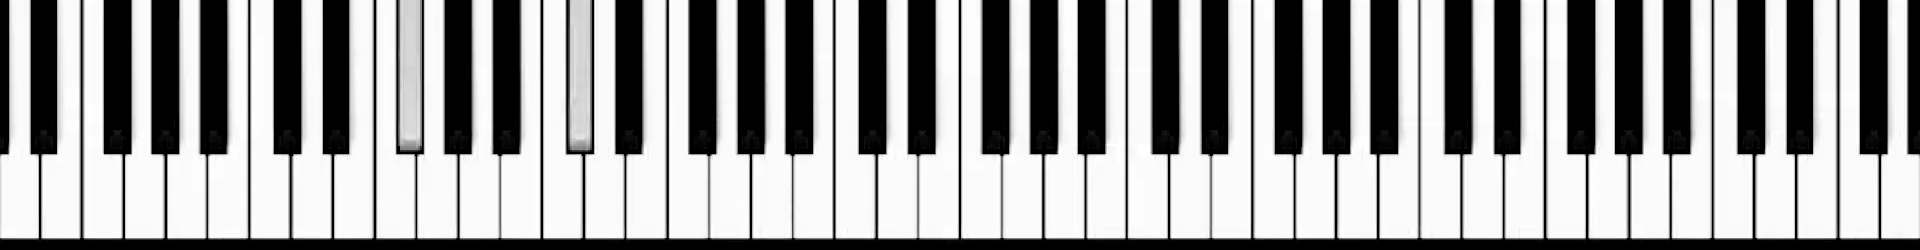

In [111]:
frame_to_pil(new_frame)

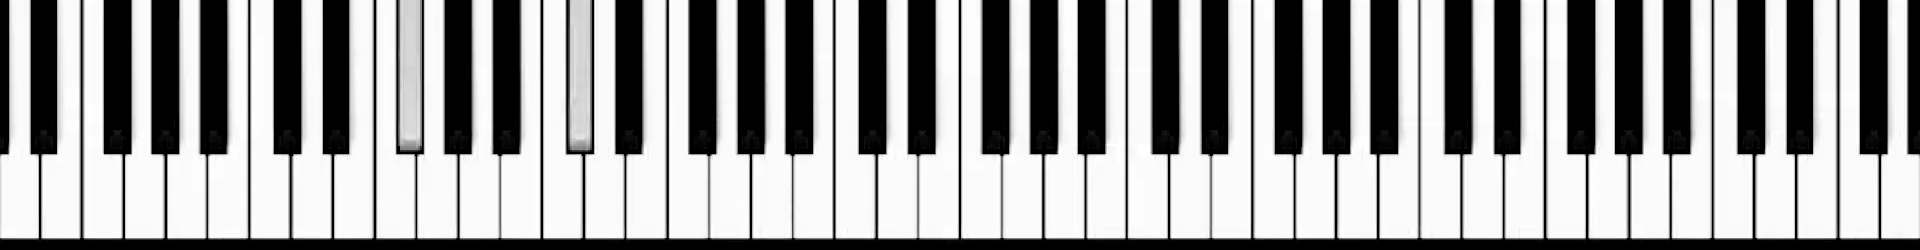

In [99]:
Image.fromarray((new_frame * 255).astype(np.uint8))